In [47]:
import numpy as np
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA, IncrementalPCA
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import pandas as pd


In [58]:
# load image data
mnist_load = pd.read_csv('toy_data/mnist.csv')
mnist = mnist_load.drop(columns='label')
print(mnist.shape)
data = mnist

(60000, 784)


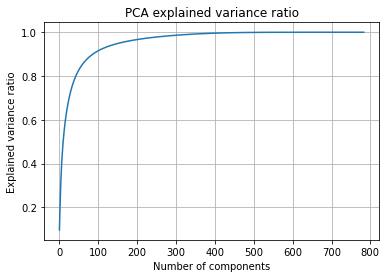

In [31]:

# pca = PCA(n_components=data.shape[1])
# pca.fit(data)
pca = IncrementalPCA(n_components=data.shape[1])
pca.fit(data)

plt.grid()
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of components')
plt.ylabel('Explained variance ratio')
plt.title('PCA explained variance ratio')

# get best number of components
n_comp_pca = 60

In [36]:
pca_red = IncrementalPCA(n_components=n_comp_pca)
data_pca_red = pca_red.fit_transform(data)
data_pca_recovered = pca_red.inverse_transform(data_pca_red)
print(data_pca_red.shape)

(60000, 60)


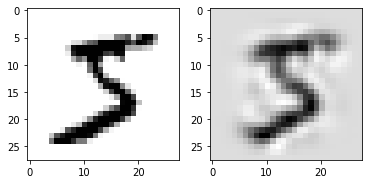

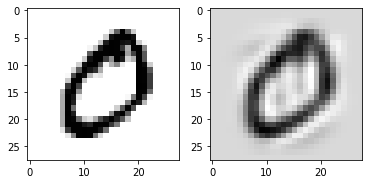

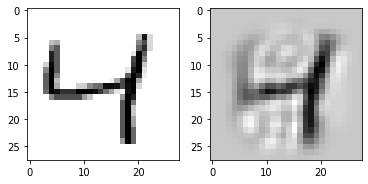

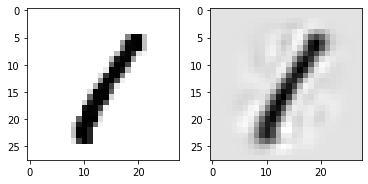

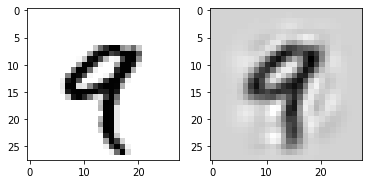

In [33]:
# compare original and compressed images
for i in range(0, 5):
    f, axarr = plt.subplots(1, 2)
    img_pca = data_pca_recovered[i,:].reshape((28, 28))
    img_orig = data.iloc[i].values.reshape((28, 28))    
    axarr[0].imshow(img_orig, cmap='gray_r')
    axarr[1].imshow(img_pca, cmap='gray_r')

In [59]:
# k means clustering
# set k at 10 to match number of labels
k = 10
# kmeans = KMeans(n_clusters=k, random_state=0).fit(data_pca_red)
kmeans = KMeans(n_clusters=k, random_state=0).fit(data)
print(kmeans.labels_)

[5 2 1 ... 5 9 0]


[[5 0 4 ... 5 6 8]
 [5 2 1 ... 5 9 0]]


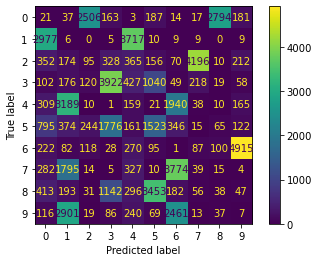

In [60]:
# create confusion matrix from kmeans results
y_true = mnist_load.iloc[:,0]
y_pred = kmeans.labels_
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
